In [32]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

# from IPython.core.display import display, HTML,clear_output
# display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Filtering & Detection

In [33]:
import numpy as np
import pylab as plt
import sys
sys.path.append('../')
from seislab.src import segyrw
from seislab.src import plot_seismic  as ps
from seislab.src import dsp

In [34]:
file_name = '../microseismic/data_lukoil_2012/233_stage01(1)_0003.sgy'
trace_descriptor = {
    'PWave':{
        'pos': 181,
        'type': 'h',
    },
    'SWave':{
        'pos': 185,
        'type': 'h',
    }
}
trace_headers = segyrw.read_trace_header(file_name, trace_descriptor=trace_descriptor)
traces = segyrw.read_traces(file_name, verbose=False)

# cast to 3C data
traces = traces.reshape(8, 3, -1)
traces = traces.transpose((0,2,1))

trace_headers['PWave'] = trace_headers['PWave'][::3] 
trace_headers['SWave'] = trace_headers['SWave'][::3] 
trace_headers


{'PWave': [394, 382, 371, 362, 350, 340, 331, 329],
 'SWave': [823, 797, 760, 727, 711, 695, 681, 683]}

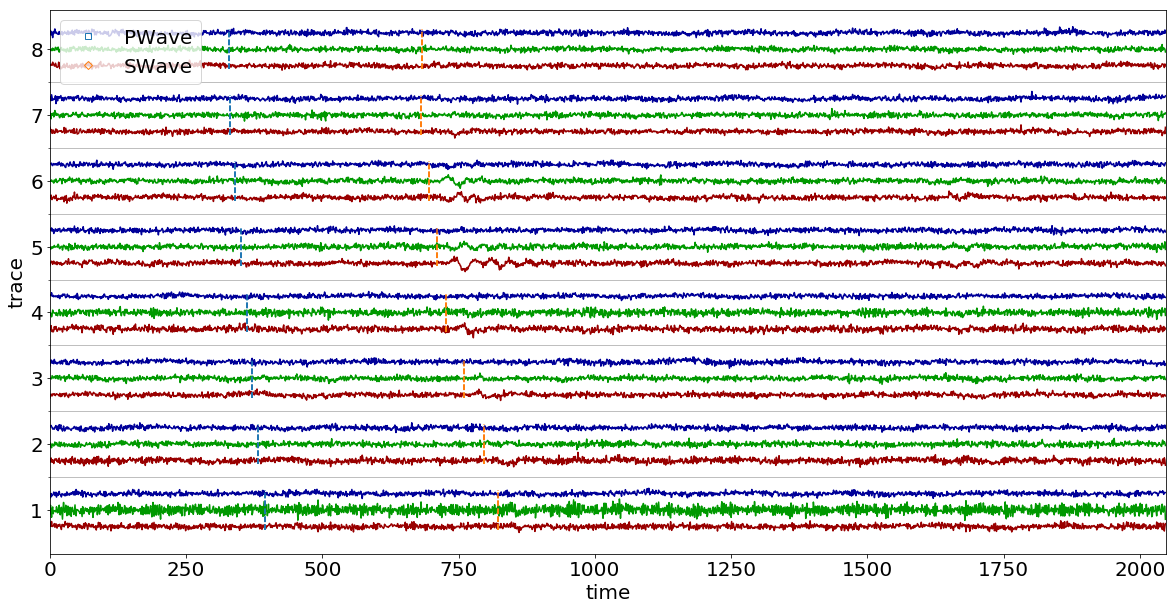

In [35]:
ps.plot_traces(
    traces,
    picks=trace_headers,
    alpha=.9, 
    dist_for_3c=1., 
    picks_curve=False,
    gain=1,
    invert_y_axis=False,
    fig_width = 20,
    picks_legend=True,
)

# Filtering

Input Traces shape (8, 2048, 3)
Amplitude Spectra shape (8, 1025, 3)
Phase Spectra shape (8, 1025, 3)


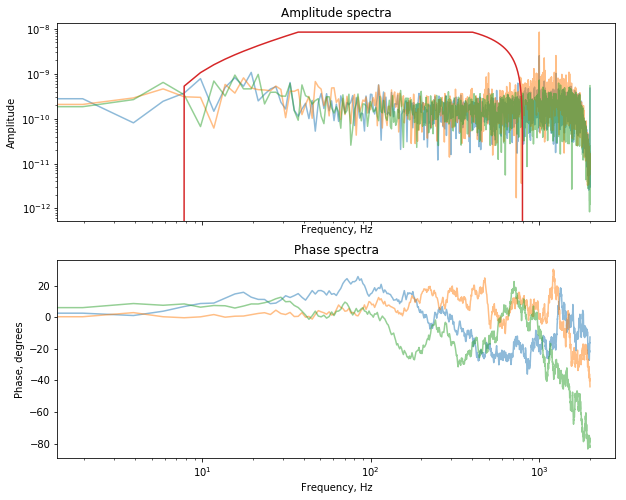

In [36]:
dt = .00025
ns = traces.shape[1]
band = [5., 40., 400., 800.]

print('Input Traces shape', traces.shape)
amplitude, phase = dsp.amplitude_n_phase_spectrum(traces)
band_pass_filter = dsp.create_band_pass_filter(ns, dt, band)

print('Amplitude Spectra shape', amplitude.shape)
print('Phase Spectra shape', phase.shape)




frange = dsp.f_range(dt, ns)

_, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

axs[0].plot(frange, amplitude[0], alpha=.5)
axs[0].plot(frange, band_pass_filter * amplitude[0].max(), label='band_pass_filter')
axs[0].set_yscale('log',basey=10) 
axs[0].set_xscale('log',basex=10) 
axs[0].set_xlabel('Frequency, Hz');
axs[0].set_ylabel('Amplitude');
axs[0].set_title('Amplitude spectra');


axs[1].plot(frange, phase[0], alpha=.5)
# axs[1].set_yscale('log',basey=10) 
axs[1].set_xscale('log',basex=10) 
axs[1].set_xlabel('Frequency, Hz');
axs[1].set_ylabel('Phase, degrees');
axs[1].set_title('Phase spectra');

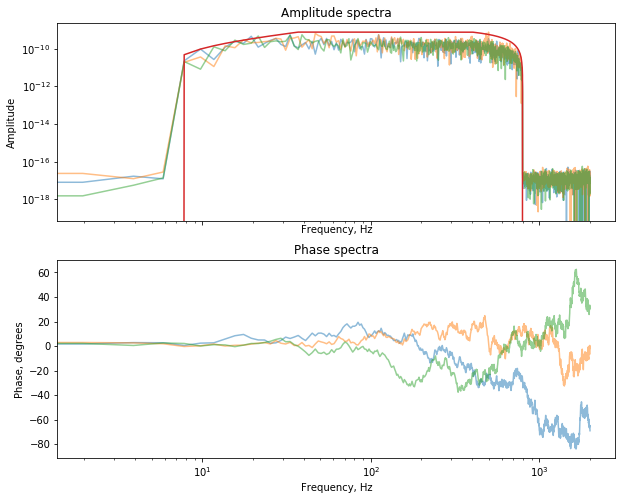

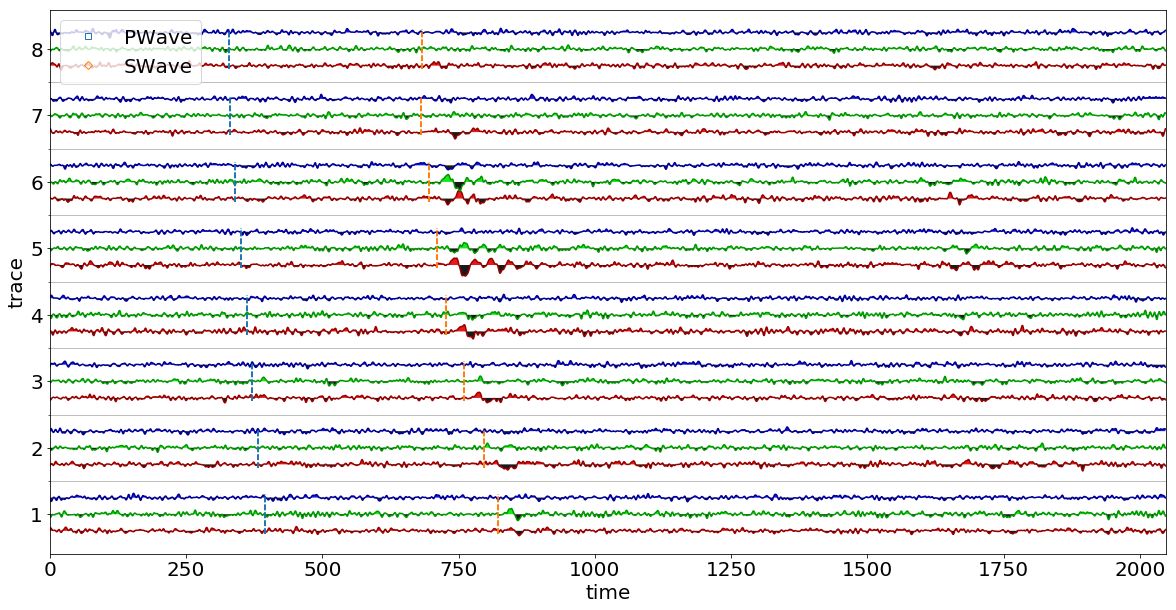

In [37]:
dt = .00025
traces_f = dsp.apply_band_pass(traces, dt, band)
# or
traces_f = dsp.apply_filter(traces, band_pass_filter)

amplitude, phase = dsp.amplitude_n_phase_spectrum(traces_f)

_, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

axs[0].plot(frange, amplitude[0], alpha=.5)
axs[0].plot(frange, band_pass_filter * amplitude[0].max(), label='band_pass_filter')
axs[0].set_yscale('log',basey=10) 
axs[0].set_xscale('log',basex=10) 
axs[0].set_xlabel('Frequency, Hz');
axs[0].set_ylabel('Amplitude');
axs[0].set_title('Amplitude spectra');


axs[1].plot(frange, phase[0], alpha=.5)
# axs[1].set_yscale('log',basey=10) 
axs[1].set_xscale('log',basex=10) 
axs[1].set_xlabel('Frequency, Hz');
axs[1].set_ylabel('Phase, degrees');
axs[1].set_title('Phase spectra');

ps.plot_traces(
    traces_f,
    picks=trace_headers,
    alpha=.9, 
    dist_for_3c=1., 
    picks_curve=False,
    fill_positive=True,
    fill_negative='k',
    gain=1,
    invert_y_axis=False,
    fig_width = 20,
    picks_legend=True,
)

# Detection

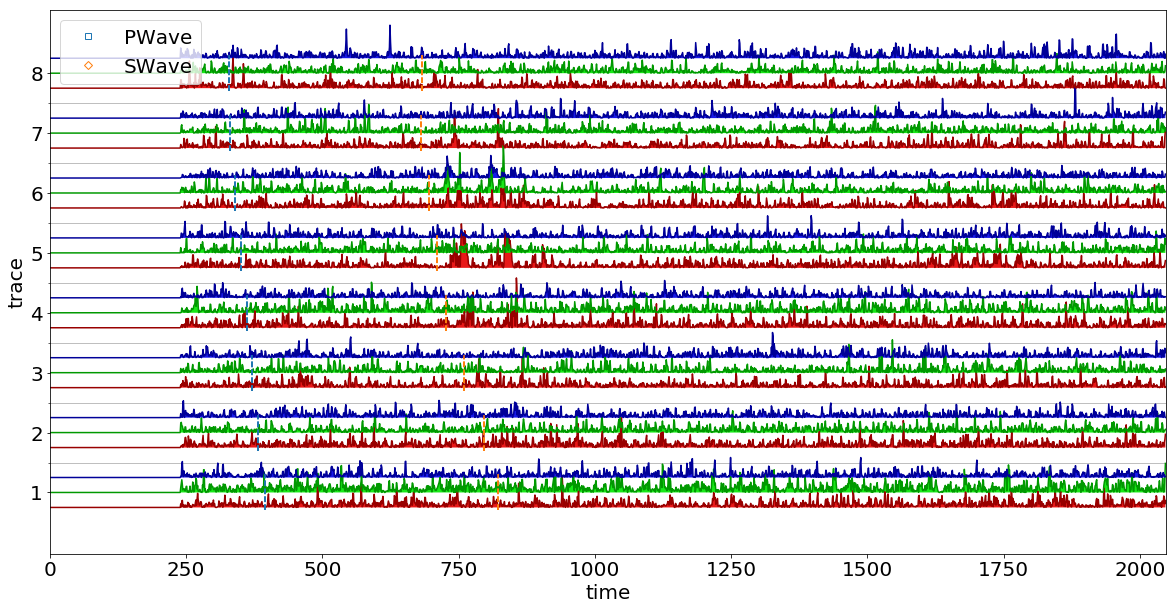

In [10]:
window_short = 80
window_long = 240
detector_sta_lta = dsp.detection_stalta(traces, window_long=window_long, window_short=window_short)

ps.plot_traces(
    detector_sta_lta,
    picks=trace_headers,
    alpha=.9, 
    dist_for_3c=1., 
    picks_curve=False,
    fill_positive=True,
    gain=5,
    invert_y_axis=False,
    fig_width = 20,
    picks_legend=True,
)

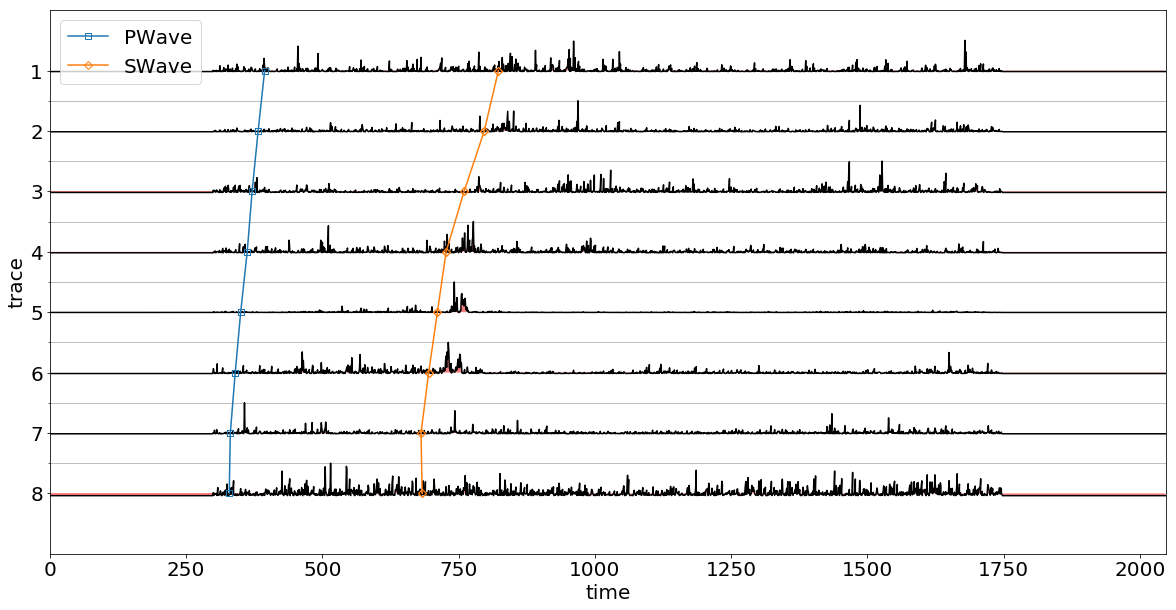

In [38]:
window = 300
detector_mer = dsp.detection_mer(traces, window=window)
detector_mer = detector_mer.sum(axis=2)
detector_mer_plot = dsp.normalize_traces(detector_mer, shift_type='mean', scale_type='maxabs', eps=1e-32)
# detector_mer /= detector_mer.max(axis=1, keepdims=True)
ps.plot_traces(
    detector_mer_plot,
    picks=trace_headers,
    fill_positive=True,
    fill_negative='r',
    picks_curve=True,
    trace_color='k',
    gain=1,
    invert_y_axis=True,
    fig_width = 20,
    picks_legend=True,
)

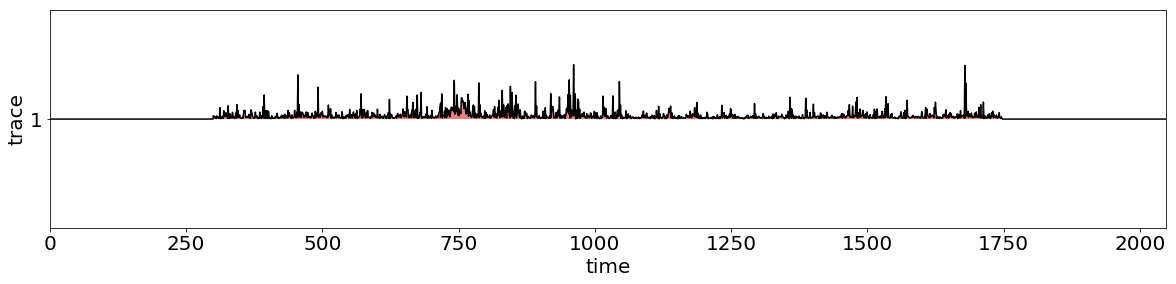

In [39]:
detector = detector_mer.sum(axis=0, keepdims=True)
ps.plot_traces(
    detector,
    fill_positive=True,
    fill_negative='r',
    trace_color='k',
    gain=1,
    invert_y_axis=True,
    fig_width=20,
    fig_height=4,
    picks_legend=True,
)

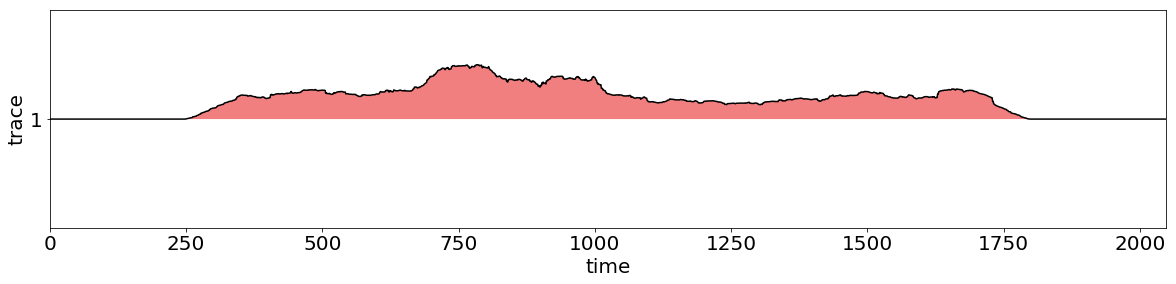

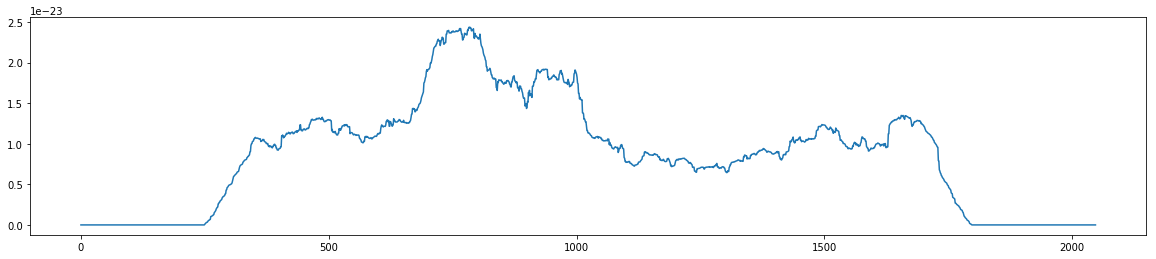

In [40]:
detector_smooth = dsp.moving_average_1d(detector, window=101, window_type='center')
ps.plot_traces(
    detector_smooth,
    fill_positive=True,
    fill_negative='r',
    trace_color='k',
    gain=1,
    invert_y_axis=True,
    fig_width=20,
    fig_height=4,
    picks_legend=True,
)

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(detector_smooth[0]);

# Triggering by ER of left and right windows

Input Traces shape (8, 2048, 3)
Detector shape (8, 2048, 3)


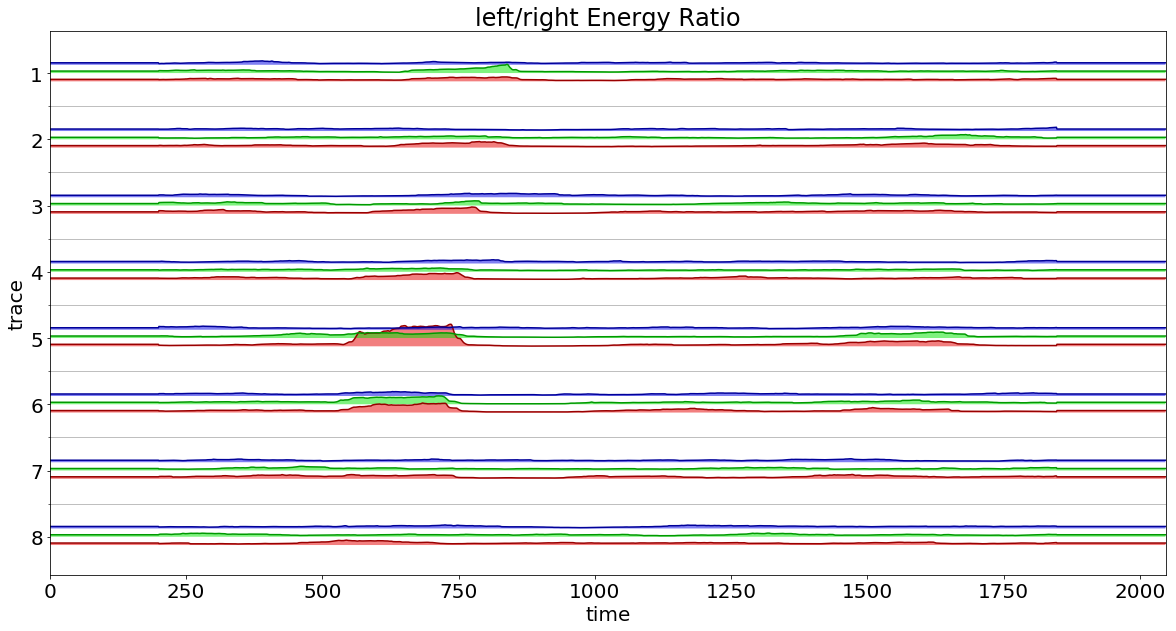

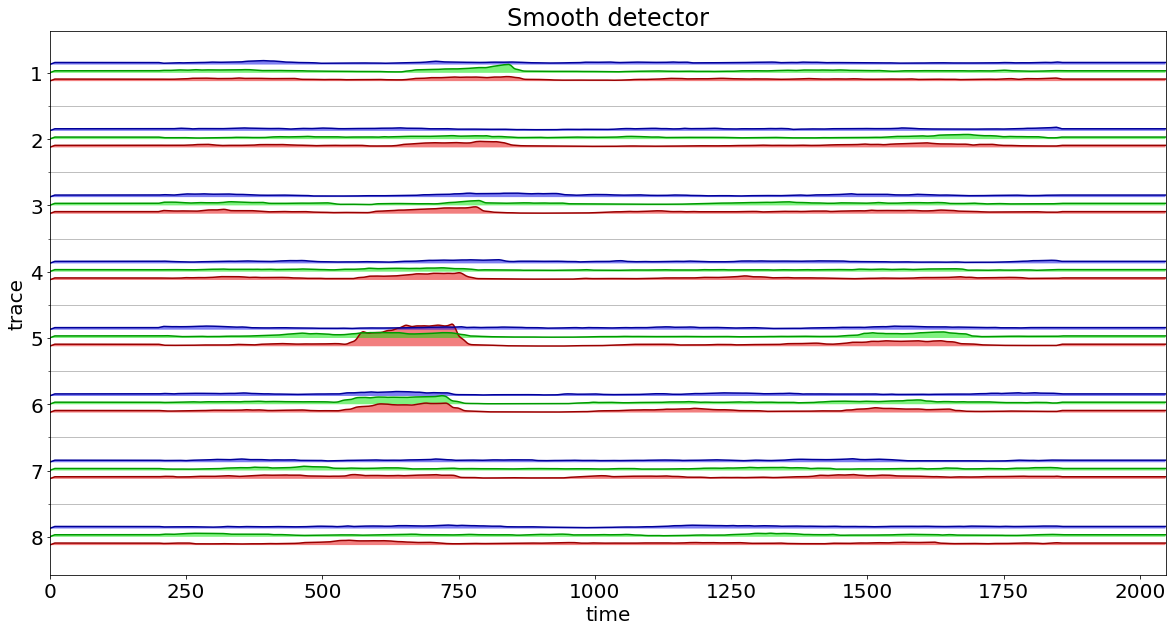

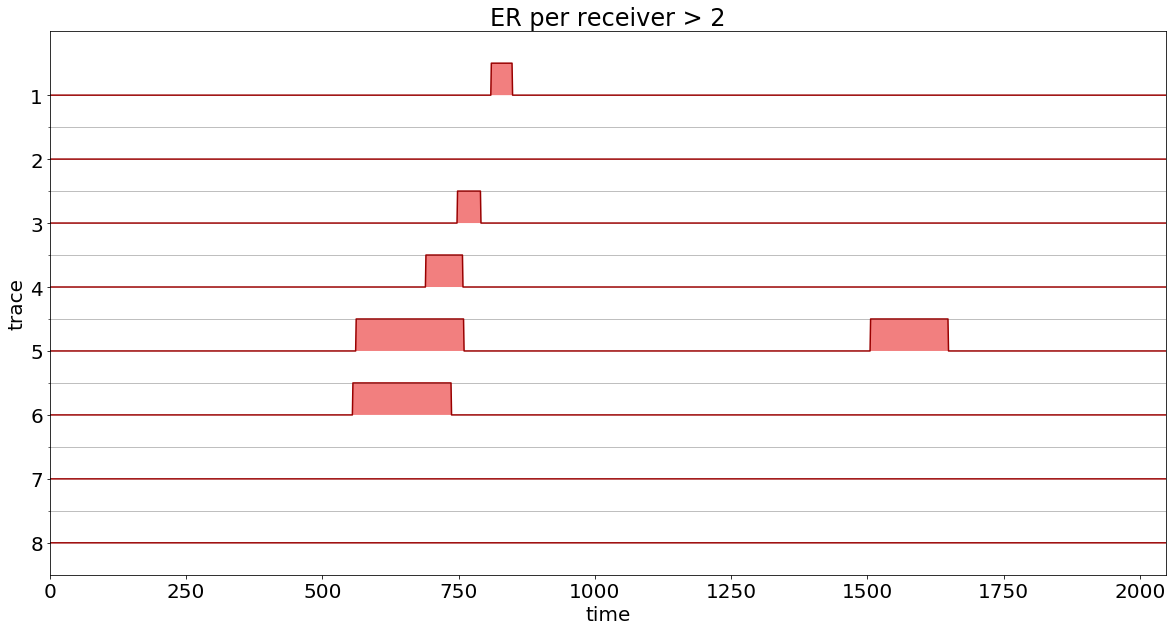

In [14]:
print('Input Traces shape', traces_f.shape)

window = 200
smooth = 10
eps = 1e-32
left = dsp.moving_average_1d(traces_f ** 2, window, axis=1, window_type='left')
right = dsp.moving_average_1d(traces_f ** 2, window, axis=1, window_type='right')
detector = right / (left + eps)
detector[:, :window] = 1
detector[:, -window::1] = 1
print('Detector shape', detector.shape)
ps.plot_traces(
    detector,
    fill_positive=True,
    gain=1,
    invert_y_axis=True,
    fig_width=20,
    picks_legend=True,
    title='left/right Energy Ratio'
)

detector = dsp.moving_average_1d(detector, smooth, axis=1, window_type='left')
ps.plot_traces(
    detector,
    fill_positive=True,
    gain=1,
    invert_y_axis=True,
    fig_width=20,
    picks_legend=True,
    title='Smooth detector'
)

detector = detector.mean(axis=2) >= 2
ps.plot_traces(
    detector,
    fill_positive=True,
    gain=1,
    invert_y_axis=True,
    fig_width=20,
    picks_legend=True,
    title='ER per receiver > 2'
)

Text(0.5, 1.0, 'Final detector')

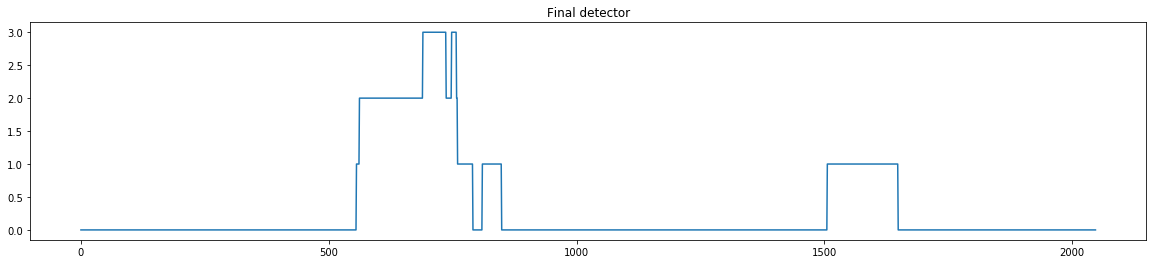

In [16]:
detection_function = detector.sum(axis=0)
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(detection_function);
# ax.scatter(pick, pick_value, c='r');
ax.set_title('Final detector')

# same function is in DSP module

Text(0.5, 1.0, 'Final detector')

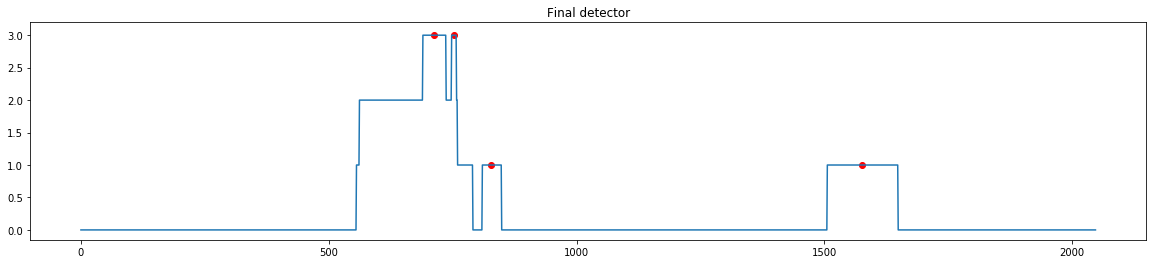

In [17]:
window = 200
smooth = 10
eps = 1e-32

detection_function = dsp.trigger_detection_function(traces_f, window=window, smooth=smooth, eps=eps)
pick, pick_value, pick_width =  dsp.get_detection_spikes(detection_function)
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(detection_function);
ax.scatter(pick, pick_value, c='r');
ax.set_title('Final detector')

Text(0.5, 1.0, 'Final detector')

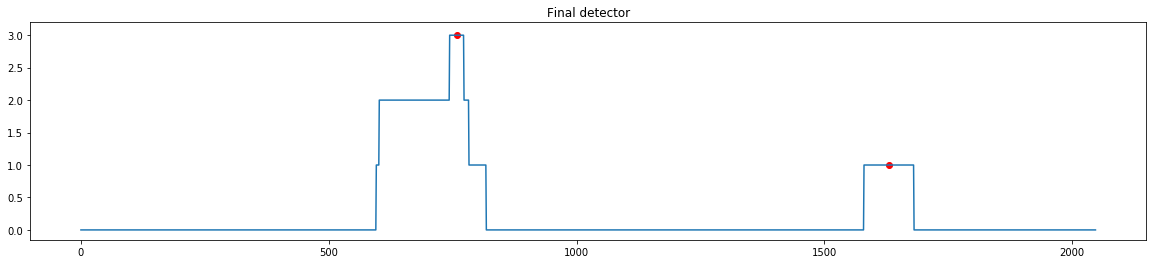

In [25]:
window = 200
smooth = 100
eps = 1e-32

detection_function = dsp.trigger_detection_function(traces_f, window=window, smooth=smooth, eps=eps)
pick, pick_value, pick_width =  dsp.get_detection_spikes(detection_function)
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(detection_function);
ax.scatter(pick, pick_value, c='r');
ax.set_title('Final detector')

# Signal SVD

In [3]:
from seislab.src import seislet

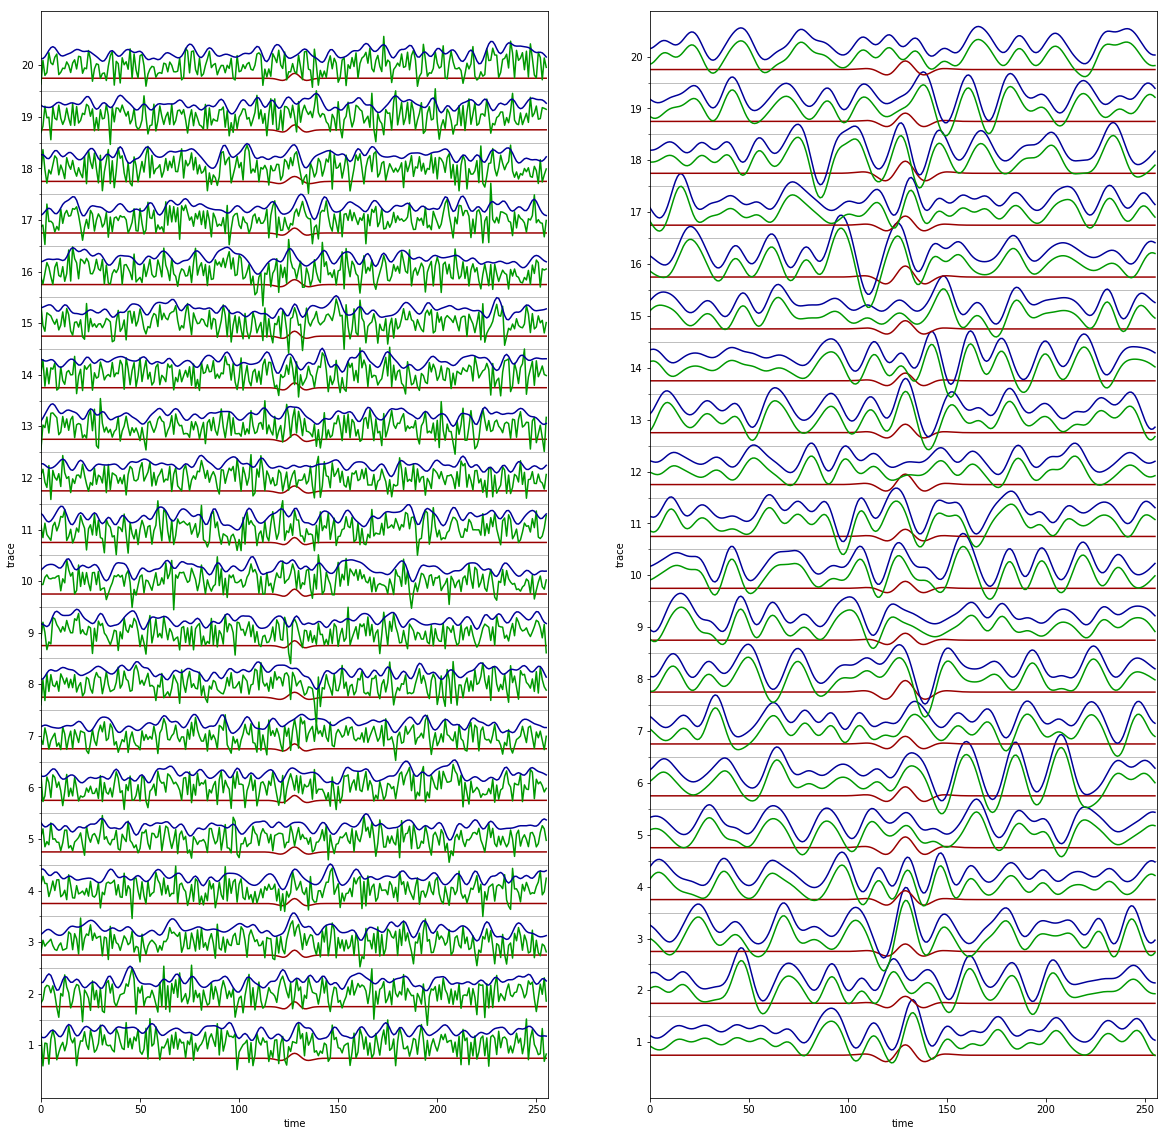

In [31]:
dt = .00025
ns = 256
nr = 20
s0 = seislet.seismic_signal(ns=ns, dt=dt, f=150)
s1 = seislet.seismic_signal(ns=ns, dt=dt, f=np.random.uniform(200, 300, nr)[...,None])
amp, phase = dsp.amplitude_n_phase_spectrum(s1)
sn = s1 + np.random.randn(*s1.shape) * 2
sf = dsp.apply_band_pass(sn, dt, [0,0,300,800])
sd = np.stack([s1, sn, sf], axis=-1)

sc = dsp.calculate_convolution(sd, s0, axis=1, mode='same')
# ps.plot_traces(amp, dt=1/(ns*dt))
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,20))
axs = axs.ravel()
ps.plot_traces(sd,dist_for_3c=1., gain=5, ax=axs[0])
ps.plot_traces(sc, dist_for_3c=1., gain=5, ax=axs[1])

# Convolve vs FFT

In [7]:
import numpy as np
import pylab as plt
from scipy.signal import fftconvolve as convolve

import sys
sys.path.append('../')
from seislab.src import segyrw
from seislab.src import plot_seismic  as ps
from seislab.src import dsp

Using TensorFlow backend.


In [167]:
s1 = np.zeros(100)
s1[10] = 1
# s1 = np.random.randn(len(s1))
w = np.zeros(len(s1))
w[:10] = 1
wc = np.ones(10)
# w = np.random.randn(len(s1))
rs = convolve(s1, w, mode='same')
rv = convolve(s1, w, mode='valid')
rf = convolve(s1, w, mode='full')[:len(s1)]
# w = np.roll(w, -31)
# w = np.fft.ifftshift(w)
s1s = np.fft.fft(s1)
ws = np.fft.fft(w)
rw = np.fft.ifft(s1s*ws)

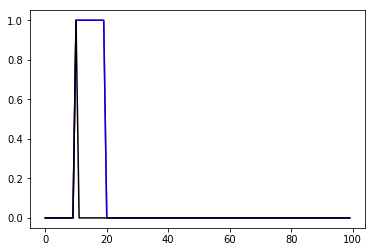

In [168]:
# plt.plot(np.fft.fftshift(rw), 'r')
plt.plot(rw, 'r')
plt.plot(rf, 'b')
plt.plot(s1, 'k')

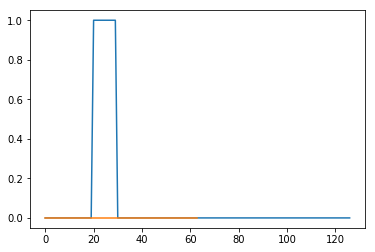

In [59]:
plt.plot(rf)
plt.plot(rs)
plt.plot(rv)
# plt.plot(s1)

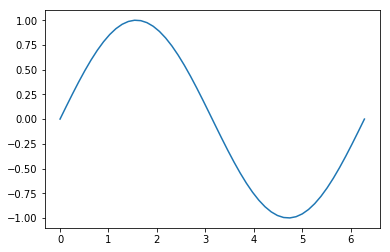

In [169]:
x = np.linspace(0, 2*np.pi, 50)
y = np.sin(x)
plt.plot(x, y)

In [ ]:
s = np.fft.fft(y)
# freq = np.fft.